In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt
import shap

from marginal import MarginalExplainer
import plot

In [2]:
n = 5000
d = 6
hidden_layers = 100
batch_size = 50
learning_rate = 0.035

In [3]:
X = np.random.randn(n, d)
y = np.sum(X[:, 1:], axis=-1) + X[:, 0] * X[:, 1] + X[:, 0] * X[:, 2] + 2 * X[:, 0] * X[:, 1] * X[:, 2]

In [4]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(d,), batch_size=batch_size))
model.add(tf.keras.layers.Dense(hidden_layers, activation=tf.keras.activations.relu, use_bias=True))
model.add(tf.keras.layers.Dense(hidden_layers, activation=tf.keras.activations.relu, use_bias=True))
model.add(tf.keras.layers.Dense(1, activation=None, use_bias=False))

In [5]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MSE,
              metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])

In [6]:
model.fit(X, y, epochs=30, verbose=2)

Train on 5000 samples
Epoch 1/30
5000/5000 - 1s - loss: 4.3514 - mean_absolute_error: 1.1775 - mean_squared_error: 4.3514
Epoch 2/30
5000/5000 - 0s - loss: 2.0949 - mean_absolute_error: 0.8052 - mean_squared_error: 2.0949
Epoch 3/30
5000/5000 - 0s - loss: 1.2467 - mean_absolute_error: 0.6560 - mean_squared_error: 1.2467
Epoch 4/30
5000/5000 - 0s - loss: 0.8806 - mean_absolute_error: 0.5461 - mean_squared_error: 0.8806
Epoch 5/30
5000/5000 - 0s - loss: 0.6600 - mean_absolute_error: 0.4624 - mean_squared_error: 0.6600
Epoch 6/30
5000/5000 - 0s - loss: 0.5994 - mean_absolute_error: 0.4263 - mean_squared_error: 0.5994
Epoch 7/30
5000/5000 - 0s - loss: 0.4280 - mean_absolute_error: 0.3637 - mean_squared_error: 0.4280
Epoch 8/30
5000/5000 - 0s - loss: 0.3320 - mean_absolute_error: 0.3236 - mean_squared_error: 0.3320
Epoch 9/30
5000/5000 - 0s - loss: 0.2789 - mean_absolute_error: 0.3020 - mean_squared_error: 0.2789
Epoch 10/30
5000/5000 - 0s - loss: 0.2394 - mean_absolute_error: 0.2710 - mean

In [7]:
num_shap_samples=100

In [8]:
primal_explainer = MarginalExplainer(model, X[num_shap_samples:], nsamples=800, representation='mobius')
primal_effects = primal_explainer.explain(X[:num_shap_samples], verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W1022 18:12:10.836783 139892570523456 base_layer.py:1814] Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


In [9]:
dual_explainer = MarginalExplainer(model, X[num_shap_samples:], nsamples=800, representation='comobius')
dual_effects = dual_explainer.explain(X[:num_shap_samples], verbose=True)

100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


In [10]:
average_explainer = MarginalExplainer(model, X[num_shap_samples:], nsamples=800, representation='average')
average_effects = average_explainer.explain(X[:num_shap_samples], verbose=True)

100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


In [11]:
model_func = lambda x: model(x).numpy()
kernel_explainer = shap.SamplingExplainer(model_func, X)
kernel_shap = kernel_explainer.shap_values(X[:num_shap_samples])

In [12]:
def unroll(x):
    ret = []
    for i in range(x.shape[-1]):
        ret.append(x[:, i])
    return np.concatenate(ret)

In [13]:
data_df = pd.DataFrame({
    'Sampled Primal Effects':  unroll(primal_effects),
    'Sampled Dual Effects':    unroll(dual_effects),
    'Sampled Average Effects': unroll(average_effects),
    'Kernel SHAP Values':      unroll(kernel_shap),
    'Primal Interaction Effects':  unroll(kernel_shap - primal_effects),
    'Dual Interaction Effects':    unroll(kernel_shap - dual_effects),
    'Average Interaction Effects': unroll(kernel_shap - average_effects),
    'Feature': [int(i / num_shap_samples) for i in range(num_shap_samples * d)],
    'Feature Value': unroll(X[:num_shap_samples])
})

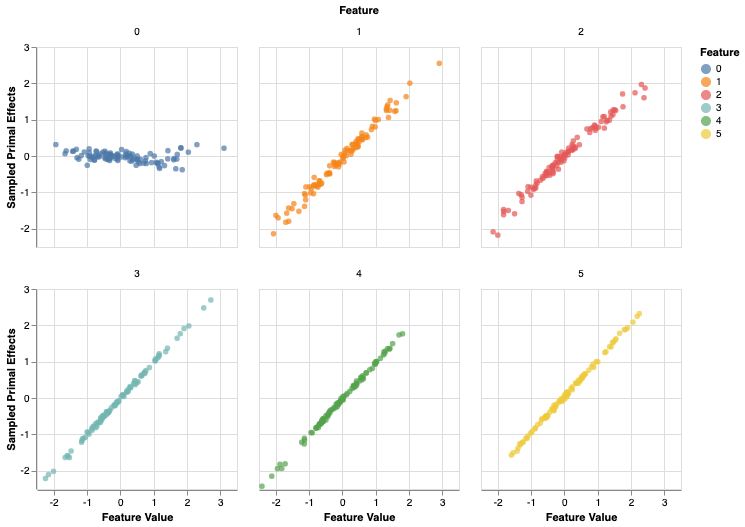

In [14]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.Y('Sampled Primal Effects:Q'),
    alt.X('Feature Value:Q'),
    alt.Color('Feature:N'),
    alt.Facet('Feature:N')
).properties(
    columns=3,
    width=200,
    height=200
)

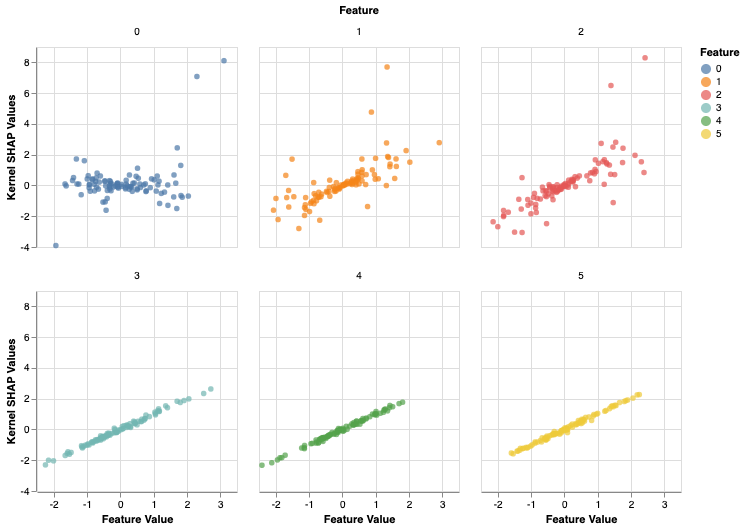

In [15]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.Y('Kernel SHAP Values:Q'),
    alt.X('Feature Value:Q'),
    alt.Color('Feature:N'),
    alt.Facet('Feature:N')
).properties(
    columns=3,
    width=200,
    height=200
)

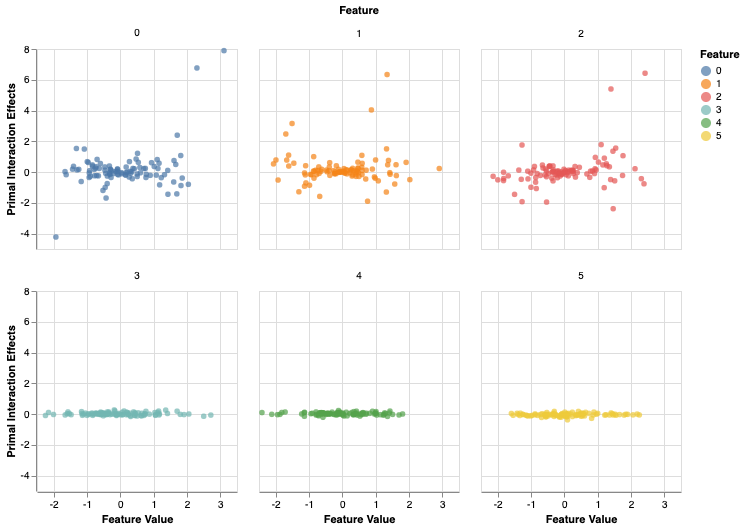

In [16]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.Y('Primal Interaction Effects:Q'),
    alt.X('Feature Value:Q'),
    alt.Color('Feature:N'),
    alt.Facet('Feature:N')
).properties(
    columns=3,
    width=200,
    height=200
)

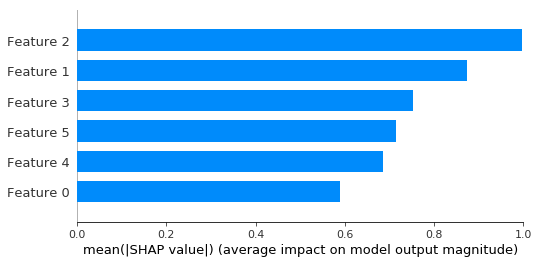

In [17]:
plot.summary_plot(kernel_shap, X[:num_shap_samples], plot_type='bar', xlim=(0.0, 1.0))

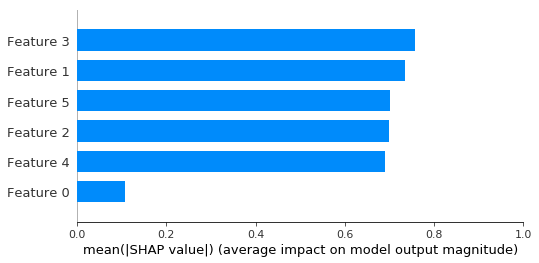

In [18]:
plot.summary_plot(primal_effects, X[:num_shap_samples], plot_type='bar', xlim=(0.0, 1.0))

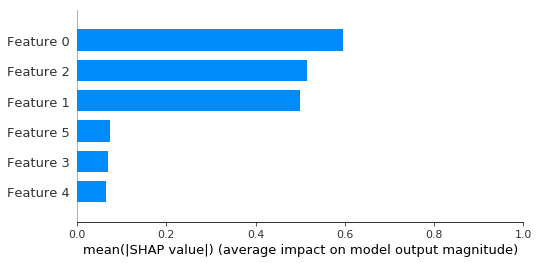

In [19]:
plot.summary_plot(kernel_shap - primal_effects, X[:num_shap_samples], plot_type='bar', xlim=(0.0, 1.0))

In [25]:
ind_df = pd.DataFrame({
    'Primal Main Effect': primal_effects[0],
    'Interaction Effect': kernel_shap[0] - primal_effects[0],
    'Feature': np.arange(kernel_shap.shape[1])
})

melted_df = pd.melt(ind_df, id_vars=['Feature'], value_name='Kernel SHAP Value', var_name='Effect Type')

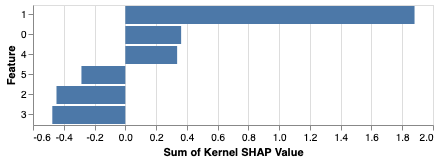

In [26]:
alt.Chart(melted_df).mark_bar().encode(
    alt.X('sum(Kernel SHAP Value):Q'),
    alt.Y('Feature:N', sort=alt.EncodingSortField(
            field="Kernel SHAP Value",
            order="descending" 
        ))
)

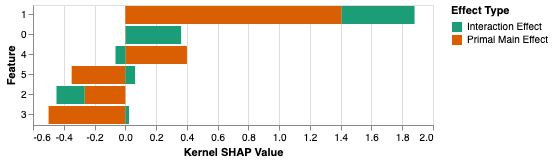

In [28]:
alt.Chart(melted_df).mark_bar().encode(
    alt.X('Kernel SHAP Value:Q'),
    alt.Y('Feature:N', sort=[1, 0, 4, 5, 2, 3]),
    alt.Color('Effect Type:N', scale=alt.Scale(scheme='dark2'))
)